In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)  # To find local version of the library
# LABELS_DIR = os.path.join(ROOT_DIR, 'data/interim')


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# import cv2
# from IPython.display import display
import skimage
from skimage.draw import polygon
import json 

tf.compat.v1.disable_eager_execution()


In [2]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

from src.data import helper

In [3]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 1 + 10

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 10

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'
  IMAGE_MAX_DIM = 256
  IMAGE_MIN_DIM = 256
  
class CustomDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,subset):
    # self.image_info = {}
    # self.class_info = {}
    # self.data_directory = dataset_dir

    classes = pd.read_csv(os.path.join(dataset_dir,'classes.csv'))
    classes = classes.set_index('CLASS_ID').T.to_dict('list')
    classes = dict([(k,classes[k][0]) for k,v in classes.items()])
    
    tmp_mapping = {}
    self.rev_mapping = {}
    for i,class_items in enumerate(classes.items()):
      self.add_class(source='cityscape',
                   class_id = i+1,
                   class_name = class_items[1])
      tmp_mapping[class_items[0]] = i+1
      self.rev_mapping[i+1]  = class_items[0]
    
    labels = pd.read_csv(os.path.join(dataset_dir, 'labels_obs.csv'), index_col=None)
    labels = labels.set_index('ID').T.to_dict('list')
    for id in labels:
      labs = labels[id][0]
      obs = labels[id][1]
      labels[id] =  (np.array([tmp_mapping[int(i)] for i in labs.split(' ')[:-1]]),np.array([int(i) for i in obs.split(' ')[:-1]]))
      
      
    # self.class_names = [d['name'] for d in self.class_info.values()]
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'

    _path = os.path.join(os.path.dirname(dataset_dir), subset+'.csv')
    SUBSET_IDs = pd.read_csv(_path, index_col=0) 
    SUBSET_IDs = [i.split('.')[0] for i in SUBSET_IDs['0'].tolist()]

    for ID in SUBSET_IDs:
    # for i in range(len(data)):
      img_path = os.path.join(dataset_dir, f'images/{ID}.png')
      img_labels = labels[ID][0]
      obs_labels = labels[ID][1]
      self.add_image(source='cityscape',
                     image_id = ID,
                     path = img_path,
                     labels = img_labels,
                     obstruction = obs_labels)
      
  def load_mask(self,id):
    # if not isinstance(id, str):
    #   id = self.image_info[id]

    img_info = self.image_info[id]
    img_name = img_info['id']
    mask_path = os.path.join(os.path.dirname(os.path.dirname(img_info['path']))
                        ,'segmentations',f'{img_name}.json')

    masks = helper.create_mask(mask_path, img_info['labels'], resize=(256,512), tmp_mapping=self.rev_mapping)
    return masks, img_info['labels'], img_info['obstruction']
  
  def image_reference(self, id):
    info = self.image_info[id]
    if info["source"] == "cityscape":
        return info["id"]
    else:
        super(self.__class__, self).image_reference(id)


In [5]:
config = CustomConfig()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
val_set.prepare()


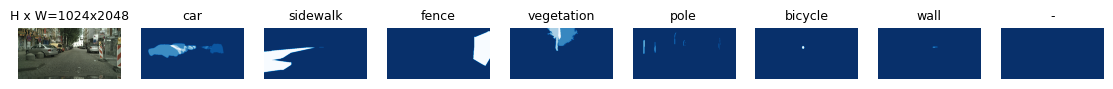

In [6]:
id = 0
img = dataset.load_image(id)
masks,labels,obs = dataset.load_mask(id)
names = dataset.class_from_source_map

visualize.display_top_masks(img,
                            masks,
                            labels,
                            names,
                            limit=8)

In [ ]:
tf.keras.backend.clear_session()
temp_log = os.path.join(ROOT_DIR,'data/external')
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

# Inference

In [12]:
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')

class InferenceConfig(CustomConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5

inference_config = InferenceConfig()
temp_log = os.path.join(ROOT_DIR,'data/external')

tf.keras.backend.clear_session()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)
model.load_weights(model_path, by_name=True, 
                   exclude=['mrcnn_class_logits','mrcnn_bbox_fc','mrcnn_bbox','mrcnn_mask'])

Instructions for updating:
Use fn_output_signature instead


In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')